In [19]:
#Importing packages
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import pandas as pd
import numpy as np

In [2]:
#Loading event data
df = pd.read_csv('Liverpool_events.csv')

#Loading xT grid used for threat calculations for each team
xt_grid_path = pd.read_csv('xT_Grid.csv')

#Loading football image for momentum graph
ball_image_path = 'ball.png'

In [5]:
df.head()

,id,event_id,minute,second,team_id,team_name,player_id,x,y,end_x,end_y,is_touch,is_shot,is_goal,type,outcome,period,name,shirt_no,position
0,2744720053,3,0,0,36,Leverkusen,299684,50.0,50.0,34.2,45.4,True,False,False,Pass,Successful,FirstHalf,Exequiel Palacios,25,MC
1,2744720087,4,0,5,36,Leverkusen,369446,45.9,48.7,40.7,71.4,True,False,False,Pass,Successful,FirstHalf,Edmond Tapsoba,12,DC
2,2744720113,5,0,7,36,Leverkusen,134946,40.7,71.4,42.1,87.3,True,False,False,Pass,Successful,FirstHalf,Jonathan Tah,4,DC
3,2744720151,6,0,9,36,Leverkusen,404832,42.6,88.5,100.0,79.7,True,False,False,Pass,Unsuccessful,FirstHalf,Piero Hincapié,3,DC
4,2744720297,4,0,22,26,Liverpool,95408,5.0,61.1,3.5,49.6,True,False,False,Pass,Successful,FirstHalf,Virgil van Dijk,4,DC


/var/folders/dv/7l2p8f4j2gbcl552tflf3zw40000gn/T/ipykernel_2990/3265669066.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_df = merged_df.append({'minute': extra_minute, 'xT_home': 0, 'xT_away': 0, 'momentum': 0}, ignore_index=True)
/var/folders/dv/7l2p8f4j2gbcl552tflf3zw40000gn/T/ipykernel_2990/3265669066.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_df = merged_df.append({'minute': extra_minute, 'xT_home': 0, 'xT_away': 0, 'momentum': 0}, ignore_index=True)
/var/folders/dv/7l2p8f4j2gbcl552tflf3zw40000gn/T/ipykernel_2990/3265669066.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_df = merged_df.append({'minute': extra_minute, 'xT_home': 0, 'xT_away': 0, 'momentum': 0}, ignore_index=True

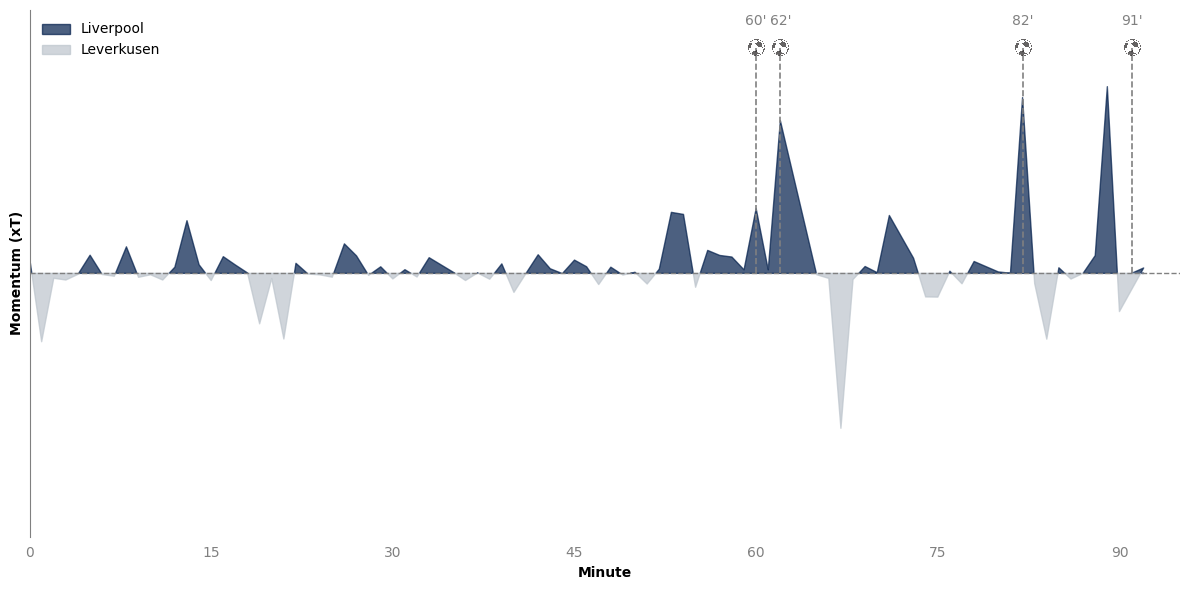

In [17]:
def plot_momentum_timeline_filled(df, ax, xt_grid_path='xT_grid.csv', ball_image_path=None):
    """
    Function to plot a momentum timeline based on xT changes over time for two teams,
    ensuring symmetrical goal markers, avoiding IndexError for extra-time goals, and adding goal minutes.
    """
    # Import the xT grid
    xT = pd.read_csv(xt_grid_path, header=None).to_numpy()
    xT_rows, xT_cols = xT.shape

    # Filter for successful passes
    df_passes = df.loc[(df['type'] == 'Pass') & (df['outcome'] == 'Successful')]

    # Ensure coordinates are within bounds
    df_passes = df_passes[
        (df_passes['x'] >= 0) & (df_passes['x'] <= 100) &
        (df_passes['y'] >= 0) & (df_passes['y'] <= 100) &
        (df_passes['end_x'] >= 0) & (df_passes['end_x'] <= 100) &
        (df_passes['end_y'] >= 0) & (df_passes['end_y'] <= 100)
    ]

    # Calculate bins for start and end points
    df_passes['x1_bin'] = pd.cut(df_passes['x'], bins=xT_cols, labels=False)
    df_passes['y1_bin'] = pd.cut(df_passes['y'], bins=xT_rows, labels=False)
    df_passes['x2_bin'] = pd.cut(df_passes['end_x'], bins=xT_cols, labels=False)
    df_passes['y2_bin'] = pd.cut(df_passes['end_y'], bins=xT_rows, labels=False)

    # Calculate xT for each event
    df_passes['start_zone_value'] = df_passes[['x1_bin', 'y1_bin']].apply(
        lambda x: xT[int(x[1])][int(x[0])] if not pd.isnull(x[0]) and not pd.isnull(x[1]) else 0, axis=1
    )
    df_passes['end_zone_value'] = df_passes[['x2_bin', 'y2_bin']].apply(
        lambda x: xT[int(x[1])][int(x[0])] if not pd.isnull(x[0]) and not pd.isnull(x[1]) else 0, axis=1
    )
    df_passes['xT'] = df_passes['end_zone_value'] - df_passes['start_zone_value']

    # Dynamically identify the teams
    home_team_id = 26
    away_team_id = 36
    home_team_name = df[df['team_id'] == home_team_id]['team_name'].iloc[0]
    away_team_name = df[df['team_id'] == away_team_id]['team_name'].iloc[0]

    # Filter and calculate xT for both teams
    home_team_df = df_passes[df_passes['team_id'] == home_team_id][['minute', 'xT']]
    away_team_df = df_passes[df_passes['team_id'] == away_team_id][['minute', 'xT']]

    # Aggregate xT by minute
    home_team_df = home_team_df.groupby('minute')['xT'].sum().reset_index()
    away_team_df = away_team_df.groupby('minute')['xT'].sum().reset_index()

    # Merge the two DataFrames on 'minute' to align them
    merged_df = pd.merge(
        home_team_df.rename(columns={'xT': 'xT_home'}),
        away_team_df.rename(columns={'xT': 'xT_away'}),
        on='minute',
        how='outer'
    ).fillna(0).sort_values('minute')

    # Calculate momentum (difference in xT per minute)
    merged_df['momentum'] = merged_df['xT_home'] - merged_df['xT_away']

    # Extend timeline to 95 minutes if needed
    for extra_minute in range(91, 96):
        if extra_minute not in merged_df['minute'].values:
            merged_df = merged_df.append({'minute': extra_minute, 'xT_home': 0, 'xT_away': 0, 'momentum': 0}, ignore_index=True)

    # Filter for goals
    goals = df.loc[df['type'] == 'Goal'][['minute', 'team_name', 'team_id']]

    # Define team colors
    home_team_color = '#001D4A'  # Home team
    away_team_color = '#BCC4CC'  # Away team

    # Plot the momentum timeline
    ax.fill_between(
        merged_df['minute'], 0, merged_df['momentum'],
        where=(merged_df['momentum'] > 0), interpolate=True, color=home_team_color, alpha=0.7, label=home_team_name
    )
    ax.fill_between(
        merged_df['minute'], 0, merged_df['momentum'],
        where=(merged_df['momentum'] < 0), interpolate=True, color=away_team_color, alpha=0.7, label=away_team_name
    )

    # Add symmetrical goal markers and minutes
    for _, row in goals.iterrows():
        goal_color = home_team_color if row['team_id'] == home_team_id else away_team_color
        minute = row['minute']
        y_offset = 0.3 if row['team_id'] == home_team_id else -0.3

        # Dashed line
        ax.plot([minute, minute], [0, y_offset], color='grey', linestyle='--', linewidth=1.2)

        # Ball marker
        if ball_image_path:  # Use custom ball image if provided
            ball_image = plt.imread(ball_image_path)
            imagebox = OffsetImage(ball_image, zoom=0.02, alpha=.7)
            ab = AnnotationBbox(imagebox, (minute, y_offset), frameon=False, zorder=5)
            ax.add_artist(ab)
        else:  # Use a circular marker
            ax.scatter(minute, y_offset, color=goal_color, edgecolor='black', s=150, zorder=5)

        # Add goal minute
        ax.text(
            minute, y_offset + 0.03 if y_offset > 0 else y_offset - 0.03,
            f"{minute}'", color='grey', fontsize=10, ha='center', zorder=6
        )

    # Set background color
    ax.set_facecolor('white')

    # Add halves separation line
    #ax.axvline(45, color='black', linestyle='--', alpha=0.5)
    #ax.axvline(90, color='black', linestyle='--', alpha=0.5)

    # Customize axis
    ax.axhline(0, color='grey', linestyle='--', linewidth=1)
    ax.set_xlabel('Minute', fontsize=10, fontweight='bold')
    ax.set_ylabel('Momentum (xT)', fontsize=10, fontweight='bold')
    ax.set_xlim(0, 95)  # Extend timeline to 95 minutes
    ax.set_ylim(-0.35, 0.35)
    ax.set_xticks([0, 15, 30, 45, 60, 75, 90])  # Set x-axis ticks to every 15 minutes
    ax.set_yticks([])
    ax.legend(loc='upper left', fontsize=10, frameon=False)

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(False)

    # Remove ticks from the top and right sides
    ax.tick_params(top=False, right=False, left=True, bottom=False)
    ax.tick_params(axis='both', colors='grey')

    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')

# Example call for Momentum timeline
fig, ax_momentum = plt.subplots(figsize=(12, 6))
plot_momentum_timeline_filled(df, ax=ax_momentum, xt_grid_path='xT_grid.csv', ball_image_path='ball.png')

# Show plot
plt.tight_layout()
plt.show()
